# Librerías

In [1]:
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import pandas as pd
import numpy as np
from scipy.ndimage import label

import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout,  RepeatVector, TimeDistributed
import matplotlib.pyplot as plt

2025-05-03 10:47:09.351885: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746262029.373514    5114 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746262029.380098    5114 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746262029.402071    5114 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746262029.402101    5114 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746262029.402103    5114 computation_placer.cc:177] computation placer alr

# Data

In [3]:
# 1. CARGA DE DATOS
train_df = pd.read_parquet("../data/train.parquet")
test_df = pd.read_parquet("../data/test.parquet")

CHANNELS = [f"channel_{i}" for i in range(41, 47)]

# 2. NORMALIZACIÓN
scaler = StandardScaler()
X_train = scaler.fit_transform(train_df.loc[train_df["is_anomaly"] == 0, CHANNELS])
X_test = scaler.transform(test_df[CHANNELS])

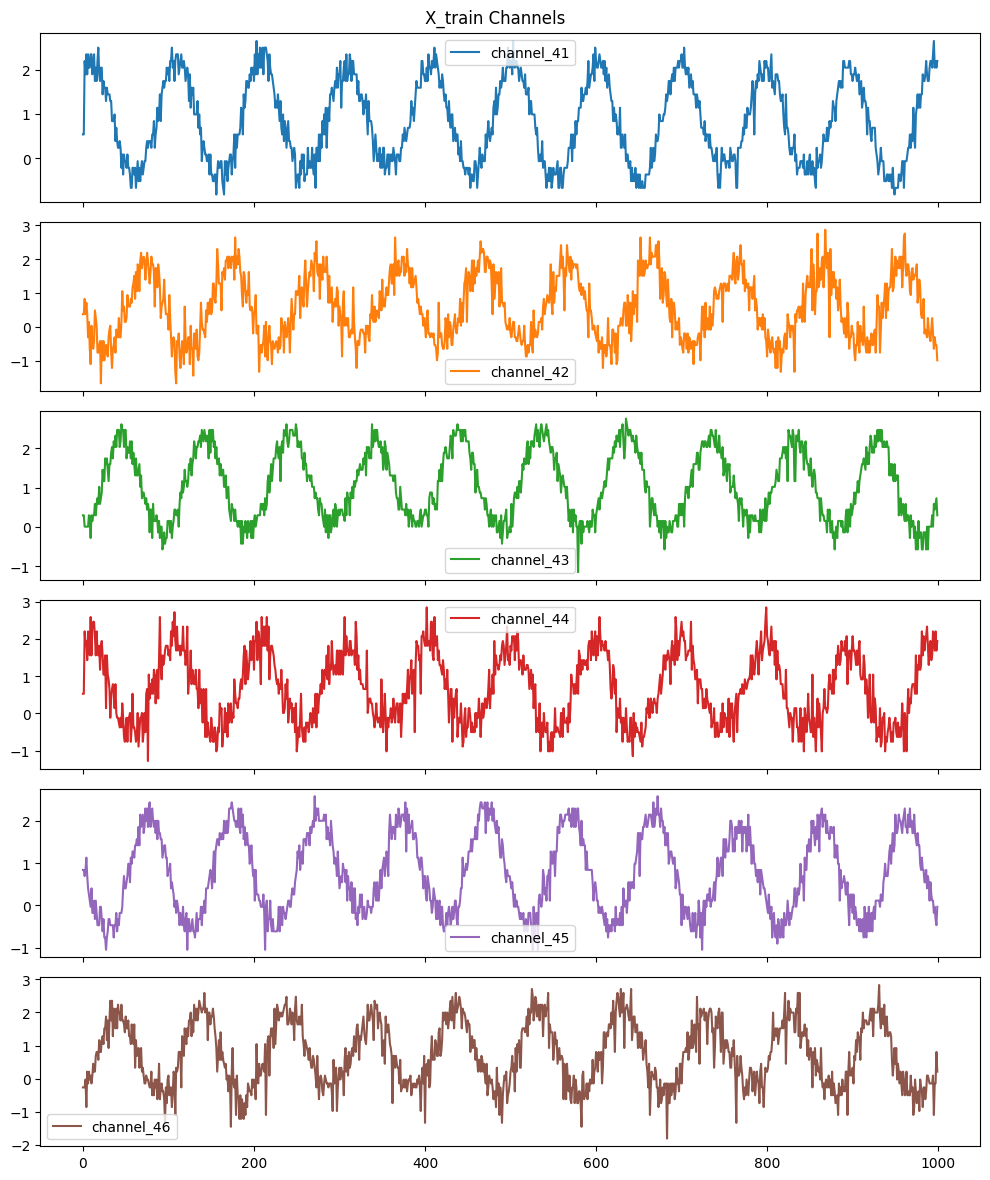

In [6]:
# Convert X_train to a DataFrame for better visualization
X_train_df = pd.DataFrame(X_train[:1_000], columns=CHANNELS)

# Plot each channel
X_train_df.plot(subplots=True, figsize=(10, 12), title="X_train Channels")
plt.tight_layout()
plt.show()

# Models

## AE

In [6]:
# 3. MODELO AUTOENCODER SIMPLE
input_dim = X_train.shape[1]
inputs = Input(shape=(input_dim,))
encoded = Dense(16, activation='relu')(inputs)
encoded = Dropout(0.2)(encoded)
bottleneck = Dense(8, activation='relu')(encoded)
encoded = Dropout(0.2)(encoded)
decoded = Dense(16, activation='relu')(bottleneck)
decoded = Dropout(0.2)(decoded)
outputs = Dense(input_dim, activation='linear')(decoded)
autoencoder = Model(inputs, outputs)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

I0000 00:00:1746259659.497903   19849 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3831 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:2d:00.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 494 (1.93 KB)

 Trainable params: 494 (1.93 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
autoencoder.fit(X_train, X_train, epochs=5, batch_size=1024, shuffle=True, verbose=1)

Epoch 1/5
12876/12876 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - loss: 0.2135
Epoch 2/5
12876/12876 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - loss: 0.1551
Epoch 3/5
12876/12876 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 0.1481
Epoch 4/5
12876/12876 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - loss: 0.1457
Epoch 5/5
12876/12876 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - loss: 0.1450


In [9]:
# 4. RECONSTRUCCIÓN Y CÁLCULO DE ERRORES
X_test_reconstructed = autoencoder.predict(X_test, batch_size=1024)
per_channel_error = np.abs(X_test - X_test_reconstructed)
z_scores = (per_channel_error - per_channel_error.mean(axis=0)) / (per_channel_error.std(axis=0) + 1e-8)
aggregated_scores = z_scores.max(axis=1)

510/510 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


## LSTM Autoencoder

In [4]:
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.regularizers import l2

timesteps = 5  # ventana temporal
input_dim = X_train.shape[1]

# Preprocesar para secuencia
def create_sequences(data, timesteps):
    return np.array([data[i:i+timesteps] for i in range(len(data)-timesteps)])

X_train_seq = create_sequences(X_train, timesteps)
X_test_seq = create_sequences(X_test, timesteps)

# Regularización
l2_reg = l2(0.001)  # Puedes ajustar este valor

inputs = Input(shape=(timesteps, input_dim))

# LSTM codificador con regularización
encoded = LSTM(64, 
               return_sequences=False, 
               dropout=0.2, 
               recurrent_dropout=0.2,
               kernel_regularizer=l2_reg)(inputs)

# Repeat
decoded = RepeatVector(timesteps)(encoded)

# LSTM decodificador con regularización
decoded = LSTM(64, 
               return_sequences=True, 
               dropout=0.2, 
               recurrent_dropout=0.2,
               kernel_regularizer=l2_reg)(decoded)

# Salida con regularización en Dense
outputs = TimeDistributed(Dense(input_dim, kernel_regularizer=l2_reg))(decoded)

# Modelo
model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')
model.summary()


I0000 00:00:1746262047.637015    5114 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4047 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:2d:00.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5, 6)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 5, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 5, 6)           │           390 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,590 (201.52 KB)

 Trainable params: 51,590 (201.52 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
model.fit(X_train_seq, X_train_seq, epochs=2, batch_size=1024, shuffle=True, verbose=1)

2025-05-03 10:47:29.139364: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1582105440 exceeds 10% of free system memory.
2025-05-03 10:47:30.432748: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1582105440 exceeds 10% of free system memory.
2025-05-03 10:47:31.517668: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1582105440 exceeds 10% of free system memory.
2025-05-03 10:47:31.914349: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1582105440 exceeds 10% of free system memory.


Epoch 1/2
12876/12876 ━━━━━━━━━━━━━━━━━━━━ 1282s 99ms/step - loss: 0.1693
Epoch 2/2
12876/12876 ━━━━━━━━━━━━━━━━━━━━ 1310s 102ms/step - loss: 0.1083


In [8]:
X_test_seq_reconstructed = model.predict(X_test_seq, batch_size=1024)
per_channel_error_seq = np.abs(X_test_seq - X_test_seq_reconstructed)
z_scores_seq = (per_channel_error_seq - per_channel_error_seq.mean(axis=0)) / (per_channel_error_seq.std(axis=0) + 1e-8)
aggregated_scores = z_scores_seq.max(axis=2).mean(axis=1)

510/510 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step


# Test

In [9]:
# 5. UMBRAL POR PERCENTIL Y PRUNING
threshold = np.percentile(aggregated_scores, 98) # Adjust this value as needed
binary_scores = (aggregated_scores > threshold).astype(int)

def prune_anomalies(anoms, min_len=10):
    anoms = anoms.copy()
    labels, num = label(anoms)
    for i in range(1, num+1):
        idx = np.where(labels == i)[0]
        if len(idx) < min_len:
            anoms[idx] = 0
    return anoms

is_anomaly = prune_anomalies(binary_scores, min_len=10)

In [17]:
is_anomaly.shape, test_df.shape

((521275,), (521280, 88))

In [16]:
type(X_test_seq)

numpy.ndarray

# Export CSV

In [ ]:
aligned_ids = test_df["id"].iloc[timesteps:].reset_index(drop=True)

submission_df = pd.DataFrame({
    "id": aligned_ids,
    "is_anomaly": is_anomaly
})

submission_df.to_csv("../out/LSTM_AE_Telemanom_0_98.csv", index=False)

In [ ]:
# 6. EXPORTACIÓN
submission_df = pd.DataFrame({
    "id": test_df["id"],
    "is_anomaly": is_anomaly
})
submission_df.to_csv("../out/LSTM_AE_Telemanom_0_98.csv", index=False)

In [19]:
df = pd.read_csv("../out/LSTM_AE_Telemanom_0_98.csv")
df["is_anomaly"].value_counts()

is_anomaly
0    516783
1      4492
Name: count, dtype: int64